In [1]:
%pylab inline
import pandas as pd
from pandas import Series, DataFrame
import re
import datetime as dt
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('figure', figsize=(20, 10))

### Data Cleaning

In [6]:
from sklearn import preprocessing

In [15]:
from sklearn import metrics

In [7]:
def cleanBosonData(infile_name):
    df = pd.read_csv(infile_name, index_col=0) # Import data and use 1st column as index
    df['Y'] = (df['Label'] == 's') * 1 # Convert 'Label' to numeric and set minority class 's' as 1
    data_clean = df.drop('Label', 1) # Drop the column 'Label'  
    
    # Create dummy variables that denotes missing values as 1 and others as 0
    mask = data_clean.isin([-999])
    colnames_missing = []
    for col in mask.columns:
        if mask[col].sum() != 0:
            colnames_missing.append(col)
            data_clean[col + '_mv'] = mask[col]*1
    
    # Replace the missing value with the mean of non-missing values
    for col in colnames_missing:
        data_clean[col] = data_clean[col].replace(-999, data_clean[col][data_clean[col+'_mv'] == 0].mean())
    
    # Rescale the data with mean = 0 and std.dev = 1
    data_clean.iloc[:, 0:9] = preprocessing.scale(data_clean.iloc[:, 0:9])
    
    return data_clean

In [8]:
data_train = cleanBosonData("boson_training_cut_2000.csv")
data_test = cleanBosonData("boson_testing_cut.csv").head(1000).copy()

In [9]:
X_train = data_train.drop('Y', 1)
Y_train = data_train['Y']
X_test = data_test.drop('Y', 1)
Y_test = data_test['Y']

In [19]:
x = pd.concat([X_train, X_test])
y = pd.concat([Y_train, Y_test])

### EDA

In [11]:
X_train.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_mass_MMC_mv,DER_deltaeta_jet_jet_mv,DER_mass_jet_jet_mv,DER_prodeta_jet_jet_mv
EventId,,,,,,,,,,,,,
100000,3.983624e-01,0.092601,0.491173,-0.444021,-1.650125e+00,-1.135322e+00,1.873193e+00,0.888048,1.120050,0,0,0,0
100001,8.633960e-01,0.608117,0.639363,-0.120744,-4.978417e-16,2.786711e-16,6.148512e-17,1.421917,-0.806390,0,1,1,1
100002,-5.882872e-16,3.421843,1.261884,-0.321306,-4.978417e-16,2.786711e-16,6.148512e-17,0.997693,-0.455521,1,1,1,1
100003,5.108589e-01,0.989159,0.028516,-0.885926,-4.978417e-16,2.786711e-16,6.148512e-17,1.209152,-0.886831,0,1,1,1
100004,1.172363e+00,-0.953916,1.504447,-0.629578,-4.978417e-16,2.786711e-16,6.148512e-17,1.967534,-0.113790,0,1,1,1


In [12]:
Y_train.head()

EventId
100000    1
100001    0
100002    0
100003    0
100004    0
Name: Y, dtype: int64

### Decision Tree
reference:

    https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve

without pruning

In [102]:
estimator = DecisionTreeClassifier(criterion='gini')
estimator.fit(X_train, np.asarray(Y_train).ravel())
auc = metrics.roc_auc_score(estimator.predict(X_test), Y_test)
print(auc)

0.7013695754840742


score is mean accuracy, we can see that train accuracy keep decreasing and test accuracy keep increasing

this indicates that the classifier is overfitting to training data. as the data size grows, training accuracy decrease

Meanwhile test accracy increase, which showns the classifier is indeed learning to generalize to unseen data

In [20]:
train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, train_sizes=np.linspace(.1, 1.0, 10), return_times=False)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

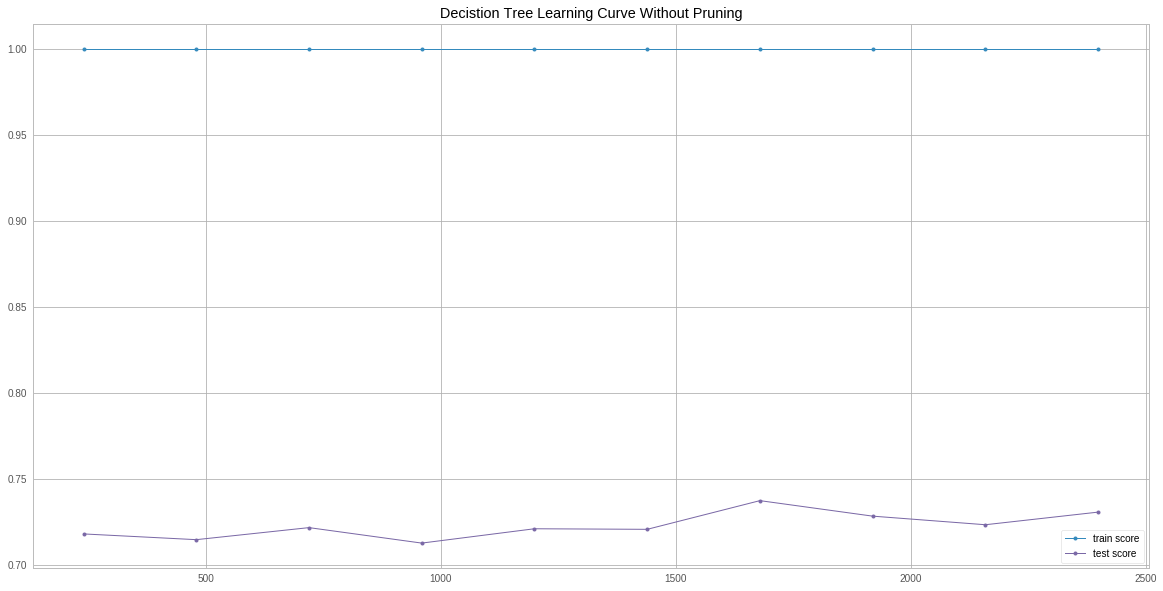

In [21]:
plt.plot(train_sizes, train_scores_mean, '.-', label='train score')
plt.plot(train_sizes, test_scores_mean, '.-', label='test score')
plt.legend(loc="best")
plt.title('Decistion Tree Learning Curve Without Pruning')
plt.show()

with pruning

In [113]:
estimator = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=2, min_samples_split=4)
estimator.fit(X_train, np.asarray(Y_train).ravel())
auc = metrics.roc_auc_score(estimator.predict(X_test), Y_test)
print(auc)

0.7401732653897322


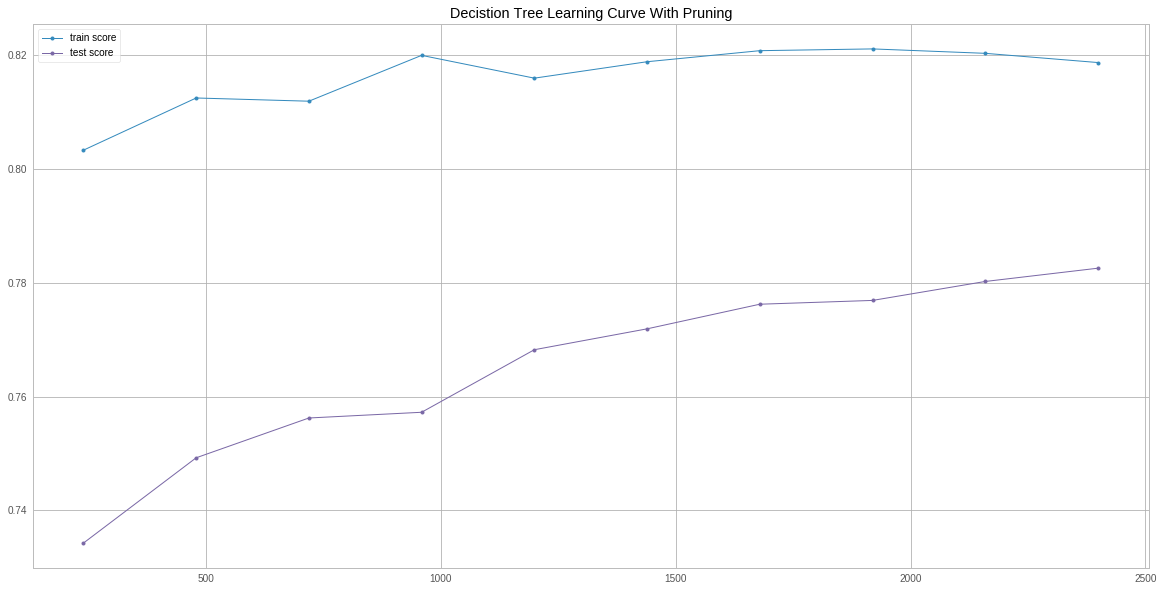

In [114]:
plt.plot(train_sizes, train_scores_mean, '.-', label='train score')
plt.plot(train_sizes, test_scores_mean, '.-', label='test score')
plt.legend(loc="best")
plt.title('Decistion Tree Learning Curve With Pruning')
plt.show()

pruning for decision tree based model is also important. Compared to no pruning was used, in Fig1, the gap between train and test is large and indiates the model is suffering from overfitting 

when pruning is added, i.e. contraining the max depth of the tree as well as min sample in a tree leaf node, the gap between train and test accuracy grealy reduced. The final test accuracy also improves, compared to unpruned version: 0.83 vs 0.8

### Neural Network
reference:

    https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_feedforward_neuralnetwork/
    https://stackoverflow.com/questions/50307707/convert-pandas-dataframe-to-pytorch-tensor

In [24]:
import torch
import torch.nn as nn
import torch.utils.data as data_utils

In [25]:
import copy

In [26]:
train_input = torch.tensor(X_train.values.astype(np.float32))
train_target = torch.tensor(Y_train.values.astype(np.int))

In [27]:
test_input = torch.tensor(X_test.values.astype(np.float32))
test_target = torch.tensor(Y_test.values.astype(np.int))

In [28]:
train_tensor = data_utils.TensorDataset(train_input, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 3000, shuffle = True)

In [29]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.module_list = nn.ModuleList()
        dim1 = input_dim
        for i in range(num_layers):
            self.module_list.append(nn.Linear(dim1, hidden_dim))
            self.module_list.append(nn.Sigmoid())
            self.module_list.append(nn.Dropout(p=0.2))
            dim1 = hidden_dim
        self.module_list.append(nn.Linear(dim1, output_dim))

    def forward(self, x):
        out = x
        for module in self.module_list:
            out = module(out)
            
        return out

In [31]:
train_input.shape

torch.Size([1999, 13])

In [45]:
model = MultiLayerPerceptron(input_dim=13, hidden_dim=200, num_layers=5, output_dim=2)

In [115]:
sum(p.numel() for p in model.parameters())

164002

In [46]:
criterion = nn.CrossEntropyLoss()

In [47]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [48]:
num_epochs = 500
train_acc_list, test_acc_list, train_loss_list, model_list = [], [], [], []

In [49]:
torch.manual_seed(7)
for epoch in range(num_epochs):
    for i, (batch_x, batch_y) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y.view(-1))
        loss.backward()
        optimizer.step()
    
        model.eval()    
        # Eval on train batch
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == batch_y.view(-1)).sum()
        train_acc = 100 * correct / len(batch_x)
        
        # Eval on test set

        outputs = model(test_input)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == test_target.view(-1)).sum()
        test_acc = 100 * correct / len(test_input)

        print('epoch', epoch, 'loss', loss.data, 'train_acc', train_acc, 'test_acc', test_acc)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        train_loss_list.append(float(loss.data.numpy()))
        model_list.append(copy.deepcopy(model))

epoch 0 loss tensor(0.6872) train_acc tensor(66.6833) test_acc tensor(65.)
epoch 1 loss tensor(0.6470) train_acc tensor(66.6833) test_acc tensor(65.)
epoch 2 loss tensor(0.6527) train_acc tensor(66.6833) test_acc tensor(65.)
epoch 3 loss tensor(0.6575) train_acc tensor(66.6833) test_acc tensor(65.)
epoch 4 loss tensor(0.6602) train_acc tensor(66.6833) test_acc tensor(65.)
epoch 5 loss tensor(0.6510) train_acc tensor(66.6833) test_acc tensor(65.)
epoch 6 loss tensor(0.6441) train_acc tensor(66.6833) test_acc tensor(65.)
epoch 7 loss tensor(0.6404) train_acc tensor(66.6833) test_acc tensor(65.)
epoch 8 loss tensor(0.6487) train_acc tensor(66.6833) test_acc tensor(65.)
epoch 9 loss tensor(0.6490) train_acc tensor(66.6833) test_acc tensor(65.)
epoch 10 loss tensor(0.6467) train_acc tensor(66.6833) test_acc tensor(65.)
epoch 11 loss tensor(0.6468) train_acc tensor(66.6833) test_acc tensor(65.)
epoch 12 loss tensor(0.6426) train_acc tensor(66.6833) test_acc tensor(65.)
epoch 13 loss tensor(0

epoch 110 loss tensor(0.5415) train_acc tensor(71.4357) test_acc tensor(71.5000)
epoch 111 loss tensor(0.5433) train_acc tensor(71.4857) test_acc tensor(71.7000)
epoch 112 loss tensor(0.5479) train_acc tensor(71.1356) test_acc tensor(71.7000)
epoch 113 loss tensor(0.5414) train_acc tensor(71.2856) test_acc tensor(71.7000)
epoch 114 loss tensor(0.5391) train_acc tensor(71.6358) test_acc tensor(71.5000)
epoch 115 loss tensor(0.5429) train_acc tensor(71.7859) test_acc tensor(71.7000)
epoch 116 loss tensor(0.5431) train_acc tensor(72.0360) test_acc tensor(71.6000)
epoch 117 loss tensor(0.5431) train_acc tensor(71.8859) test_acc tensor(71.5000)
epoch 118 loss tensor(0.5456) train_acc tensor(72.0360) test_acc tensor(71.3000)
epoch 119 loss tensor(0.5460) train_acc tensor(72.0860) test_acc tensor(71.2000)
epoch 120 loss tensor(0.5478) train_acc tensor(72.1861) test_acc tensor(71.2000)
epoch 121 loss tensor(0.5425) train_acc tensor(71.9360) test_acc tensor(71.4000)
epoch 122 loss tensor(0.5474

epoch 214 loss tensor(0.5109) train_acc tensor(75.3377) test_acc tensor(74.1000)
epoch 215 loss tensor(0.5069) train_acc tensor(75.2876) test_acc tensor(74.4000)
epoch 216 loss tensor(0.5160) train_acc tensor(75.3877) test_acc tensor(74.5000)
epoch 217 loss tensor(0.5083) train_acc tensor(75.5878) test_acc tensor(74.5000)
epoch 218 loss tensor(0.5001) train_acc tensor(75.7879) test_acc tensor(74.6000)
epoch 219 loss tensor(0.5104) train_acc tensor(75.6378) test_acc tensor(74.6000)
epoch 220 loss tensor(0.5008) train_acc tensor(76.1381) test_acc tensor(75.)
epoch 221 loss tensor(0.5042) train_acc tensor(76.1381) test_acc tensor(75.)
epoch 222 loss tensor(0.5016) train_acc tensor(76.2381) test_acc tensor(75.1000)
epoch 223 loss tensor(0.4951) train_acc tensor(76.2381) test_acc tensor(75.3000)
epoch 224 loss tensor(0.5037) train_acc tensor(76.4882) test_acc tensor(75.4000)
epoch 225 loss tensor(0.4996) train_acc tensor(76.4882) test_acc tensor(75.4000)
epoch 226 loss tensor(0.5004) train_

epoch 318 loss tensor(0.4426) train_acc tensor(80.8404) test_acc tensor(80.7000)
epoch 319 loss tensor(0.4451) train_acc tensor(80.8404) test_acc tensor(80.4000)
epoch 320 loss tensor(0.4367) train_acc tensor(80.9405) test_acc tensor(80.3000)
epoch 321 loss tensor(0.4487) train_acc tensor(80.8904) test_acc tensor(80.3000)
epoch 322 loss tensor(0.4538) train_acc tensor(80.9405) test_acc tensor(80.3000)
epoch 323 loss tensor(0.4448) train_acc tensor(80.9405) test_acc tensor(80.6000)
epoch 324 loss tensor(0.4430) train_acc tensor(80.8904) test_acc tensor(80.5000)
epoch 325 loss tensor(0.4465) train_acc tensor(80.8904) test_acc tensor(80.5000)
epoch 326 loss tensor(0.4395) train_acc tensor(80.8904) test_acc tensor(80.5000)
epoch 327 loss tensor(0.4423) train_acc tensor(80.9405) test_acc tensor(80.4000)
epoch 328 loss tensor(0.4422) train_acc tensor(80.9905) test_acc tensor(80.3000)
epoch 329 loss tensor(0.4429) train_acc tensor(80.9905) test_acc tensor(80.5000)
epoch 330 loss tensor(0.4323

epoch 421 loss tensor(0.4291) train_acc tensor(81.2906) test_acc tensor(80.9000)
epoch 422 loss tensor(0.4319) train_acc tensor(81.3907) test_acc tensor(80.8000)
epoch 423 loss tensor(0.4301) train_acc tensor(81.3407) test_acc tensor(80.8000)
epoch 424 loss tensor(0.4282) train_acc tensor(81.4407) test_acc tensor(80.8000)
epoch 425 loss tensor(0.4254) train_acc tensor(81.4407) test_acc tensor(81.)
epoch 426 loss tensor(0.4224) train_acc tensor(81.2906) test_acc tensor(80.8000)
epoch 427 loss tensor(0.4385) train_acc tensor(81.3907) test_acc tensor(80.8000)
epoch 428 loss tensor(0.4307) train_acc tensor(81.0905) test_acc tensor(80.5000)
epoch 429 loss tensor(0.4282) train_acc tensor(81.0905) test_acc tensor(80.3000)
epoch 430 loss tensor(0.4353) train_acc tensor(81.2406) test_acc tensor(80.7000)
epoch 431 loss tensor(0.4204) train_acc tensor(81.1406) test_acc tensor(80.9000)
epoch 432 loss tensor(0.4240) train_acc tensor(81.1906) test_acc tensor(80.6000)
epoch 433 loss tensor(0.4276) tr

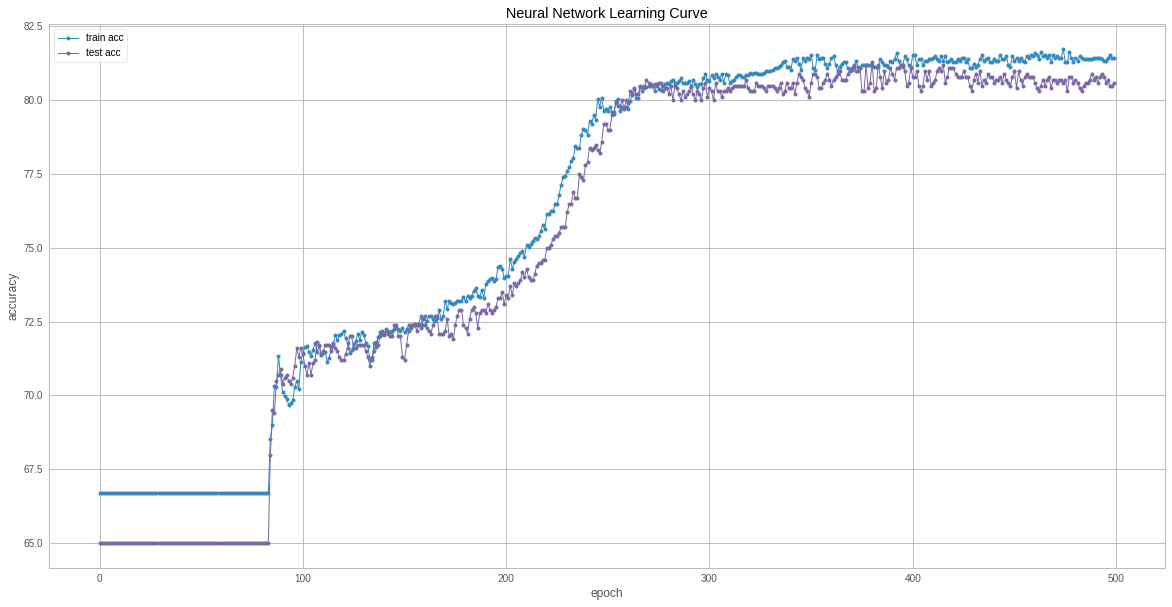

In [50]:
plt.plot(train_acc_list, '.-', label='train acc')
plt.plot(test_acc_list, '.-', label='test acc')
plt.legend(loc="best")
plt.title('Neural Network Learning Curve')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

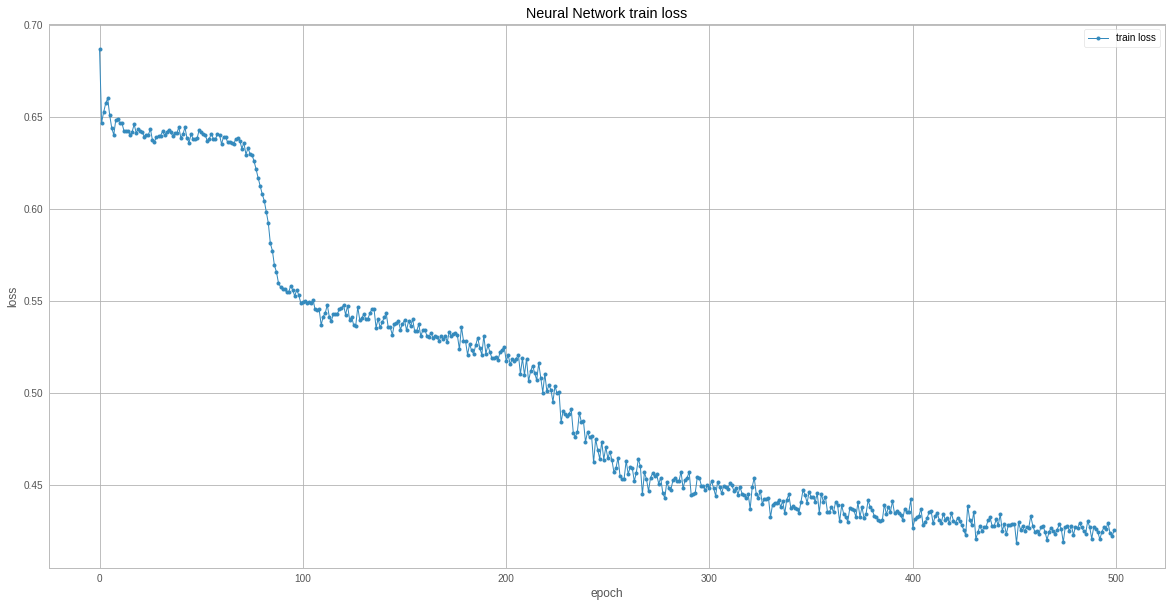

In [51]:
plt.plot(train_loss_list, '.-', label='train loss')
plt.legend(loc="best")
plt.title('Neural Network train loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [62]:
outputs = model_list[380](test_input)
_, predicted = torch.max(outputs.data, 1)
auc = metrics.roc_auc_score(predicted, Y_test)
print(auc)

0.7966088216984518


### Boosting
reference:
    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html

In [87]:
import sklearn.ensemble as ske

no pruning

In [88]:
estimator = ske.GradientBoostingClassifier(n_estimators= 500, random_state= 2)
estimator.fit(X_train, np.asarray(Y_train).ravel())
auc = metrics.roc_auc_score(estimator.predict(X_test), Y_test)
print(auc)

0.7686472819216182


In [89]:
train_loss, test_loss = [], []
for i, Y_pred in enumerate(estimator.staged_decision_function(X_train)):
    train_loss.append(estimator.loss_(Y_train.values.ravel(), Y_pred))
for i, Y_pred in enumerate(estimator.staged_decision_function(X_test)):
    test_loss.append(estimator.loss_(Y_test.values.ravel(), Y_pred))

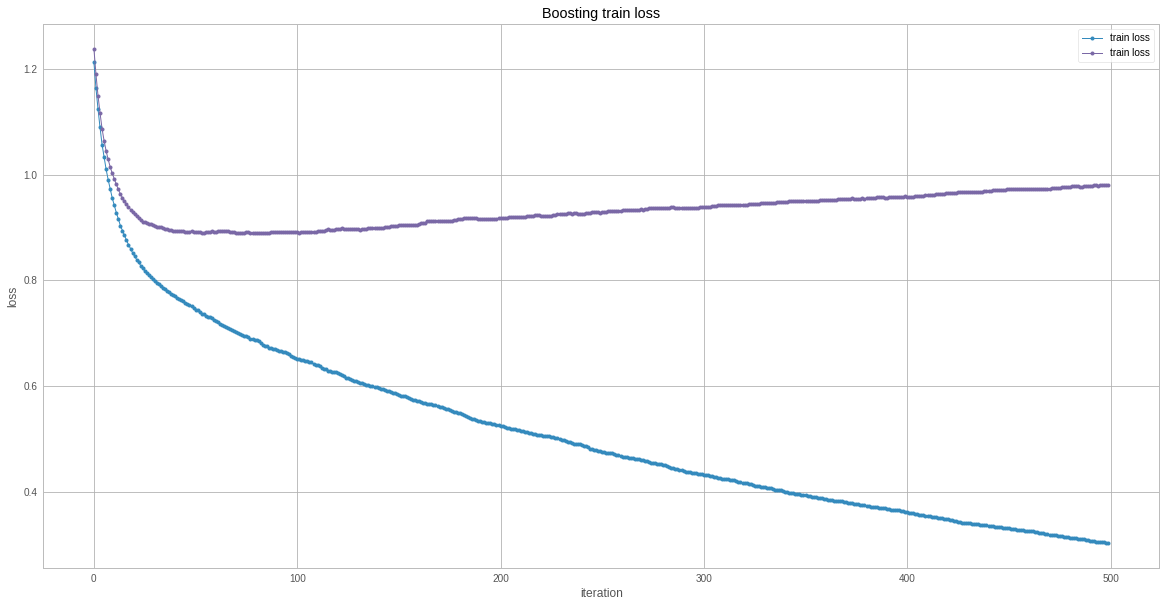

In [90]:
plt.plot(train_loss, '.-', label='train loss')
plt.plot(test_loss, '.-', label='train loss')
plt.legend(loc="best")
plt.title('Boosting train loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

with pruning

In [91]:
estimator = ske.GradientBoostingClassifier(n_estimators= 500, max_depth=2, random_state= 2)
estimator.fit(X_train, np.asarray(Y_train).ravel())
auc = metrics.roc_auc_score(estimator.predict(X_test), Y_test)
print(auc)

0.7660155467768655


In [92]:
train_loss, test_loss = [], []
for i, Y_pred in enumerate(estimator.staged_decision_function(X_train)):
    train_loss.append(estimator.loss_(Y_train.values.ravel(), Y_pred))
for i, Y_pred in enumerate(estimator.staged_decision_function(X_test)):
    test_loss.append(estimator.loss_(Y_test.values.ravel(), Y_pred))

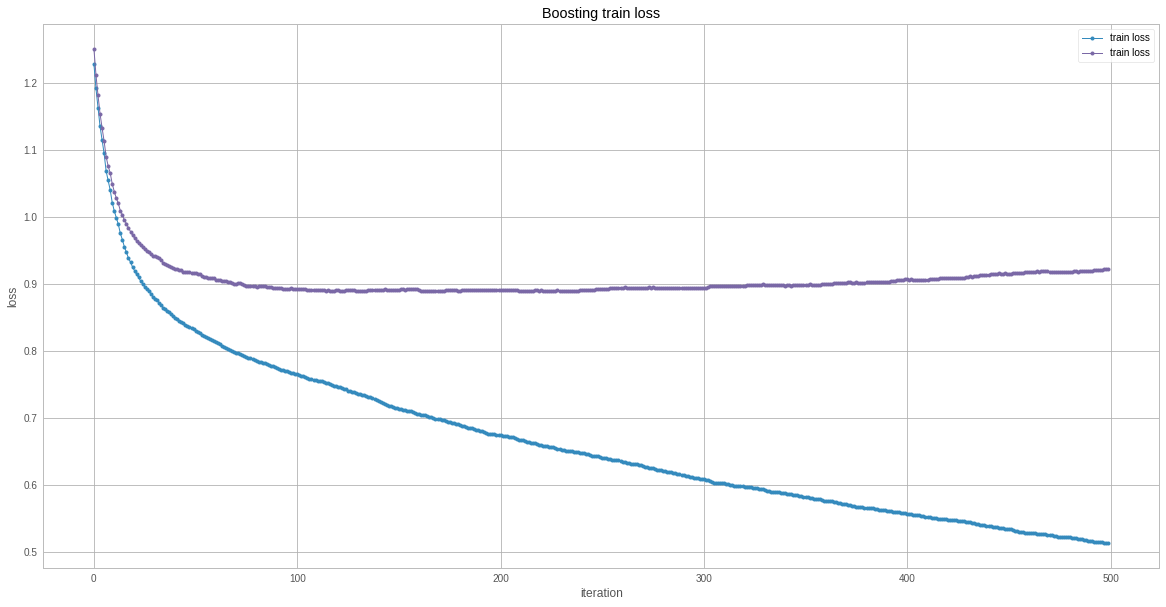

In [93]:
plt.plot(train_loss, '.-', label='train loss')
plt.plot(test_loss, '.-', label='train loss')
plt.legend(loc="best")
plt.title('Boosting train loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

### SVM
reference:
    
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    
default poly kernel degree is 3

In [73]:
from sklearn import svm

In [74]:
for kernel in ('poly', 'rbf'):
    for c in [0.5,1,2,4,8,16]:
        estimator = svm.SVC(C=c, kernel=kernel)
        estimator.fit(X_train, np.asarray(Y_train).ravel())
        auc = metrics.roc_auc_score(estimator.predict(X_test), Y_test)
        print('C', c, 'kernel', kernel, 'auc', auc)    

C 0.5 kernel poly auc 0.7520784181552633
C 1 kernel poly auc 0.736999539806719
C 2 kernel poly auc 0.736690208592412
C 4 kernel poly auc 0.7515863843520355
C 8 kernel poly auc 0.7553669183641295
C 16 kernel poly auc 0.7593661432797534
C 0.5 kernel rbf auc 0.7877742946708464
C 1 kernel rbf auc 0.7872243208507019
C 2 kernel rbf auc 0.787095835380894
C 4 kernel rbf auc 0.7843407050413738
C 8 kernel rbf auc 0.7849931941923775
C 16 kernel rbf auc 0.7756919716817794


In [75]:
estimator = svm.SVC(C=1, kernel='rbf')

In [76]:
train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, train_sizes=np.linspace(.1, 1.0, 10), return_times=False)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

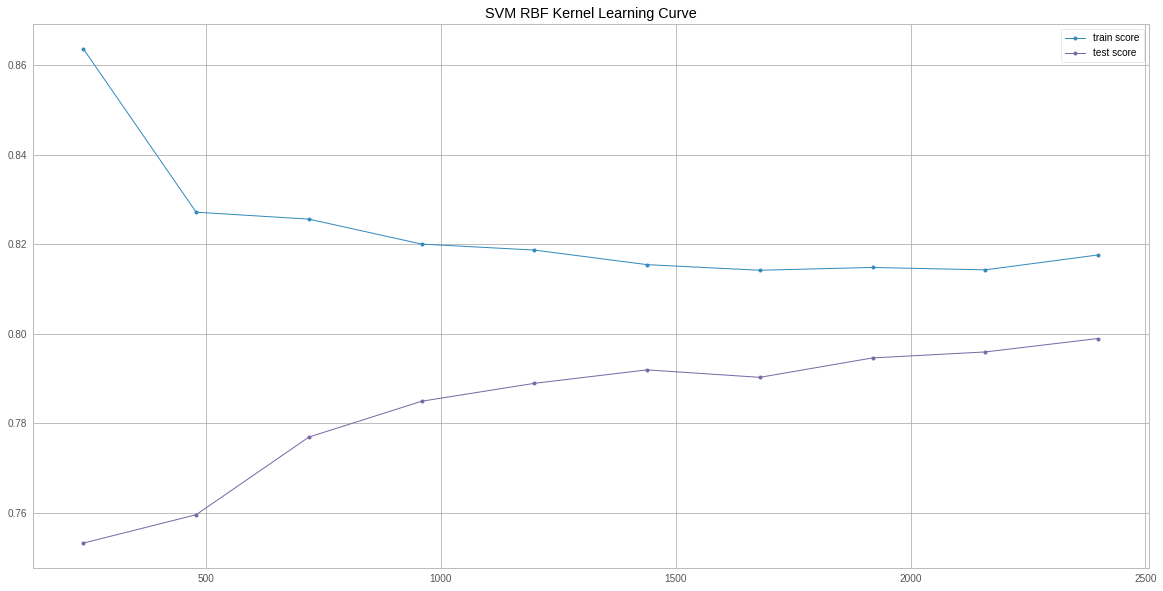

In [77]:
plt.plot(train_sizes, train_scores_mean, '.-', label='train score')
plt.plot(train_sizes, test_scores_mean, '.-', label='test score')
plt.legend(loc="best")
plt.title('SVM RBF Kernel Learning Curve')
plt.show()

In [78]:
estimator = svm.SVC(C=16, kernel='poly')

In [79]:
train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, train_sizes=np.linspace(.1, 1.0, 10), return_times=False)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

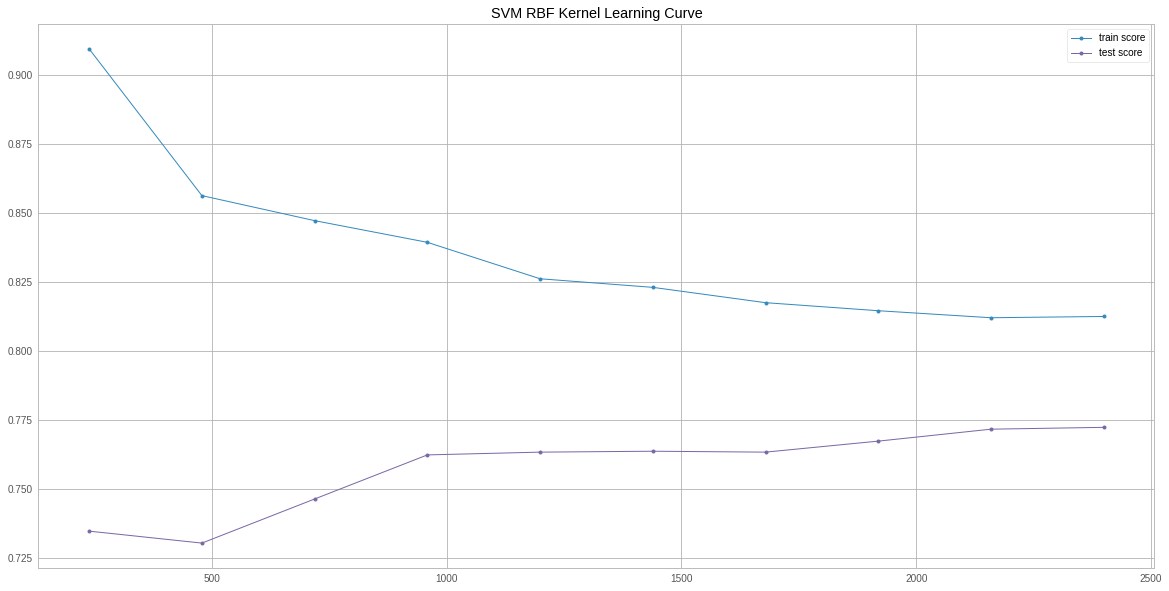

In [80]:
plt.plot(train_sizes, train_scores_mean, '.-', label='train score')
plt.plot(train_sizes, test_scores_mean, '.-', label='test score')
plt.legend(loc="best")
plt.title('SVM RBF Kernel Learning Curve')
plt.show()

### KNN
reference:
    
    https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [81]:
from sklearn.neighbors import KNeighborsClassifier

In [82]:
k_list, auc_list = [], []
for k in [1,2,4,8,16,32,64]:
    estimator = KNeighborsClassifier(n_neighbors=k)
    estimator.fit(X_train, Y_train)
    auc = metrics.roc_auc_score(estimator.predict(X_test), Y_test)
    print('k', k, 'auc', auc)
    k_list.append(k)
    auc_list.append(auc)

k 1 auc 0.6958680250297358
k 2 auc 0.7335665897416809
k 4 auc 0.7483059255662747
k 8 auc 0.7681265802136856
k 16 auc 0.7657984415791466
k 32 auc 0.7484357747515642
k 64 auc 0.7541943358364881


In [83]:
estimator = KNeighborsClassifier(n_neighbors=8)

In [84]:
train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, train_sizes=np.linspace(.1, 1.0, 10), return_times=False)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

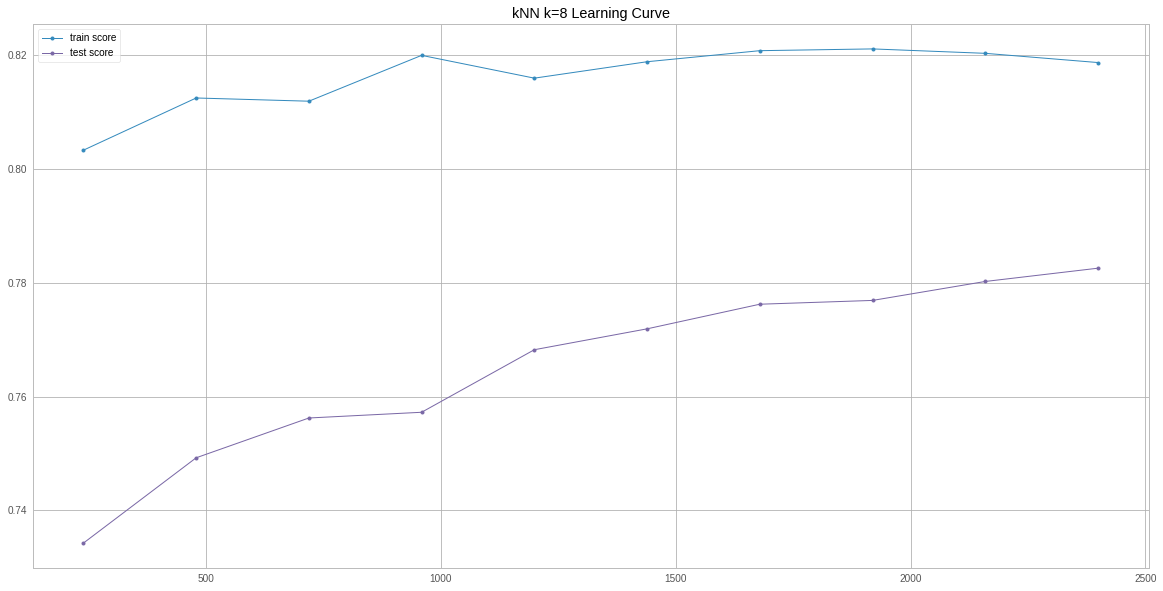

In [86]:
plt.plot(train_sizes, train_scores_mean, '.-', label='train score')
plt.plot(train_sizes, test_scores_mean, '.-', label='test score')
plt.legend(loc="best")
plt.title('kNN k=8 Learning Curve')
plt.show()